# Proyecto de Predicción de Churn en Telecomunicaciones

 ## 1.Importaciones y Configuración General

In [32]:
#Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, auc)


# Cargar datos

In [33]:
# Cargar data
data = pd.read_csv('dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv') #Importar dataset desde el directorio del repositorio
data.head(10)  #Mostrar las primeras 10 filas del dataset

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [34]:
print(data.describe(include='all')) #Mostrar estadísticas descriptivas del dataset

        customerID gender  SeniorCitizen Partner Dependents       tenure  \
count         7043   7043    7043.000000    7043       7043  7043.000000   
unique        7043      2            NaN       2          2          NaN   
top     3186-AJIEK   Male            NaN      No         No          NaN   
freq             1   3555            NaN    3641       4933          NaN   
mean           NaN    NaN       0.162147     NaN        NaN    32.371149   
std            NaN    NaN       0.368612     NaN        NaN    24.559481   
min            NaN    NaN       0.000000     NaN        NaN     0.000000   
25%            NaN    NaN       0.000000     NaN        NaN     9.000000   
50%            NaN    NaN       0.000000     NaN        NaN    29.000000   
75%            NaN    NaN       0.000000     NaN        NaN    55.000000   
max            NaN    NaN       1.000000     NaN        NaN    72.000000   

       PhoneService MultipleLines InternetService OnlineSecurity  ...  \
count         

In [35]:
print("Data shape: ")
data.shape # Mostrar las dimensiones del dataset

Data shape: 


(7043, 21)

# Exploratory Data Analysis

In [36]:
# Información básica del dataset
print("Información del dataset:") 
data.info() # Mostrar información del dataset
print("\n" + "="*50)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling 

In [37]:
# Valores faltantes
print("\nValores faltantes por columna:")
print(data.isnull().sum()) # Mostrar la cantidad de valores faltantes por columna, busca los nulos y los suma por cada columna.
print("\n" + "="*50)


Valores faltantes por columna:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64



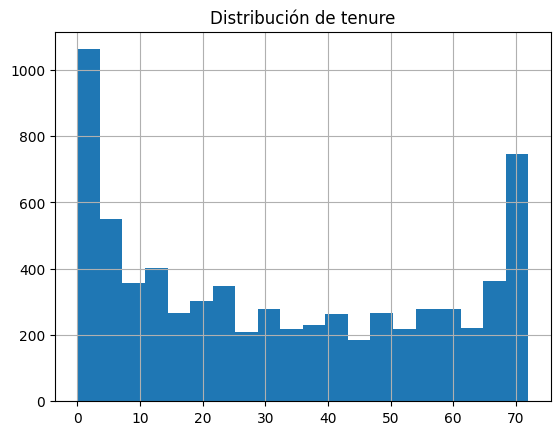

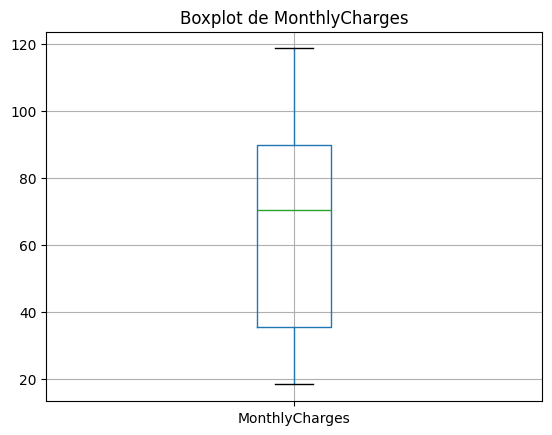

In [38]:
# Histograma
data['tenure'].hist(bins=20) # Mostrar un histograma de la columna 'tenure'
plt.title('Distribución de tenure') 
plt.show()

# Boxplot
data.boxplot(column='MonthlyCharges') # Mostrar un boxplot de la columna 'MonthlyCharges'
plt.title('Boxplot de MonthlyCharges')
plt.show()


In [39]:
# Convertir 'TotalCharges' a numérico, manejando errores
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce') # Convertir la columna 'TotalCharges' a tipo numérico, reemplazando errores con NaN

In [40]:
data[['tenure','MonthlyCharges','TotalCharges']].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


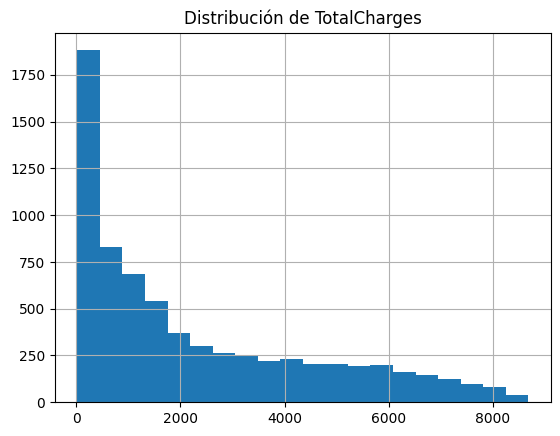

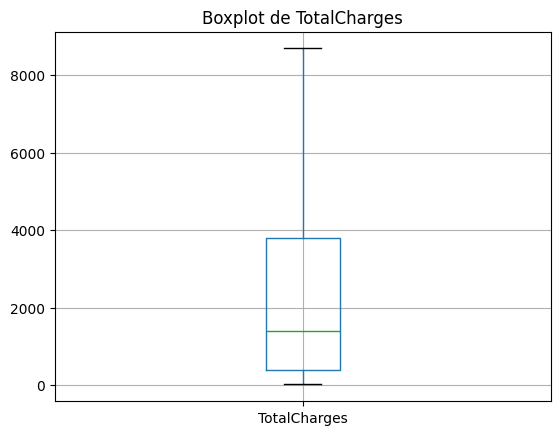

In [41]:
# Histograma de TotalCharges
data['TotalCharges'].hist(bins=20)
plt.title('Distribución de TotalCharges')
plt.show()

# Boxplot de TotalCharges
data.boxplot(column='TotalCharges')
plt.title('Boxplot de TotalCharges')
plt.show()


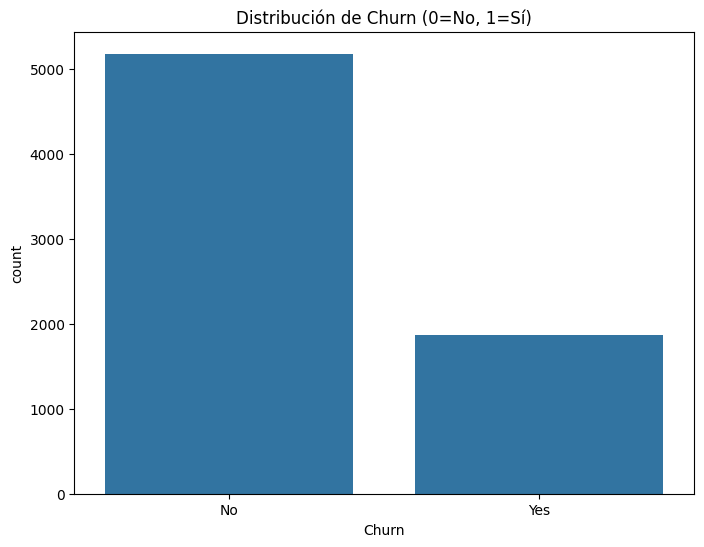

In [42]:
# Análisis de la variable objetivo (Churn)
plt.figure(figsize=(8,6)) # Crear una figura de tamaño 8x6
sns.countplot(x='Churn', data=data) # Crear un gráfico de barras para la variable 'Churn'
plt.title('Distribución de Churn (0=No, 1=Sí)') 
plt.show()

In [43]:
churn_rate = data['Churn'].value_counts(normalize=True) # Calcular la tasa de churn
print(f"\nTasa de Churn: {churn_rate[1]*100:.2f}%") # Mostrar la tasa de churn en porcentaje


Tasa de Churn: 26.54%


C:\Users\Aledm\AppData\Local\Temp\ipykernel_26312\1296933434.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"\nTasa de Churn: {churn_rate[1]*100:.2f}%") # Mostrar la tasa de churn en porcentaje


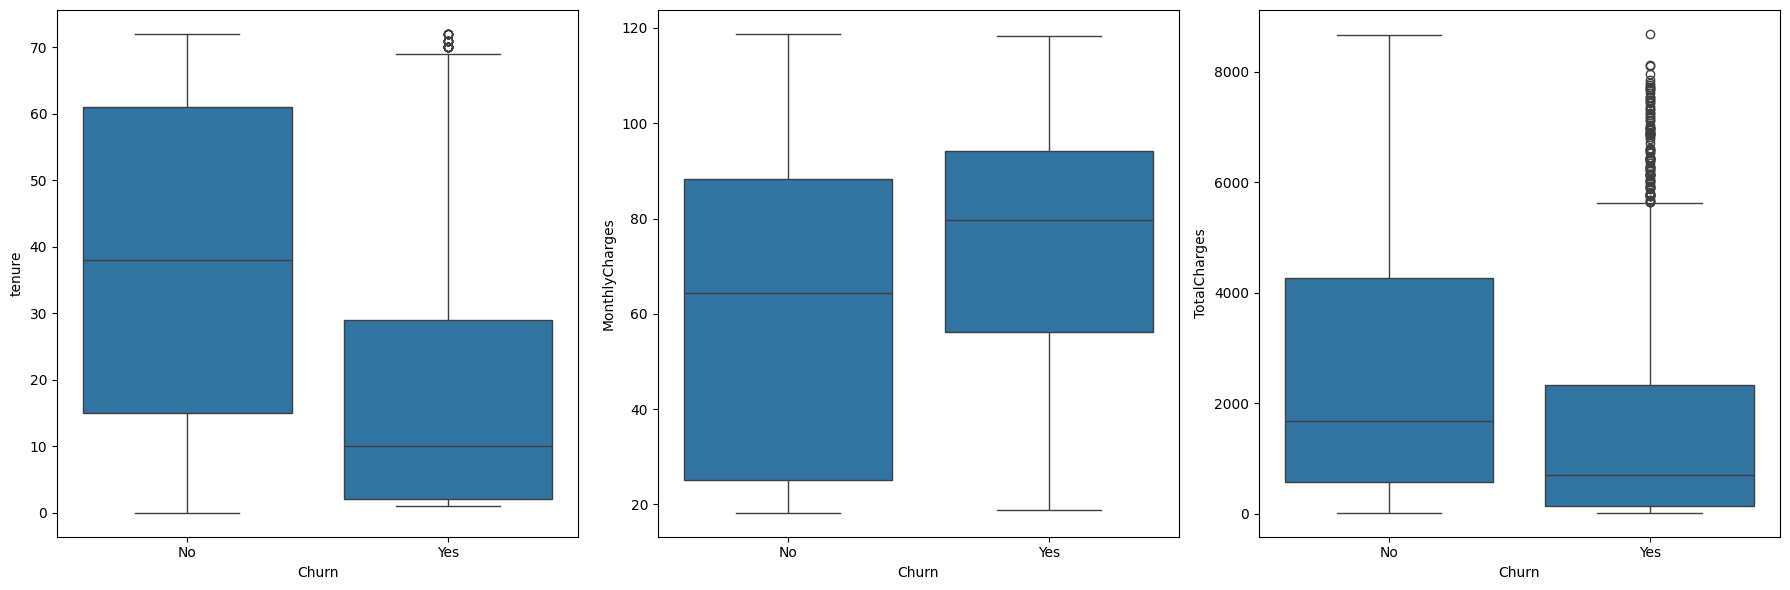

In [44]:
# Relación entre variables clave y Churn
fig, ax = plt.subplots(1, 3, figsize=(18,6)) # Crear una figura con 3 subgráficas en una fila
sns.boxplot(x='Churn', y='tenure', data=data, ax=ax[0])     # Crear un boxplot de 'tenure' vs 'Churn'
sns.boxplot(x='Churn', y='MonthlyCharges', data=data, ax=ax[1]) # Crear un boxplot de 'MonthlyCharges' vs 'Churn'
sns.boxplot(x='Churn', y='TotalCharges', data=data, ax=ax[2]) # Crear un boxplot de 'TotalCharges' vs 'Churn'
plt.tight_layout() # Ajustar el layout para evitar superposiciones
plt.show()

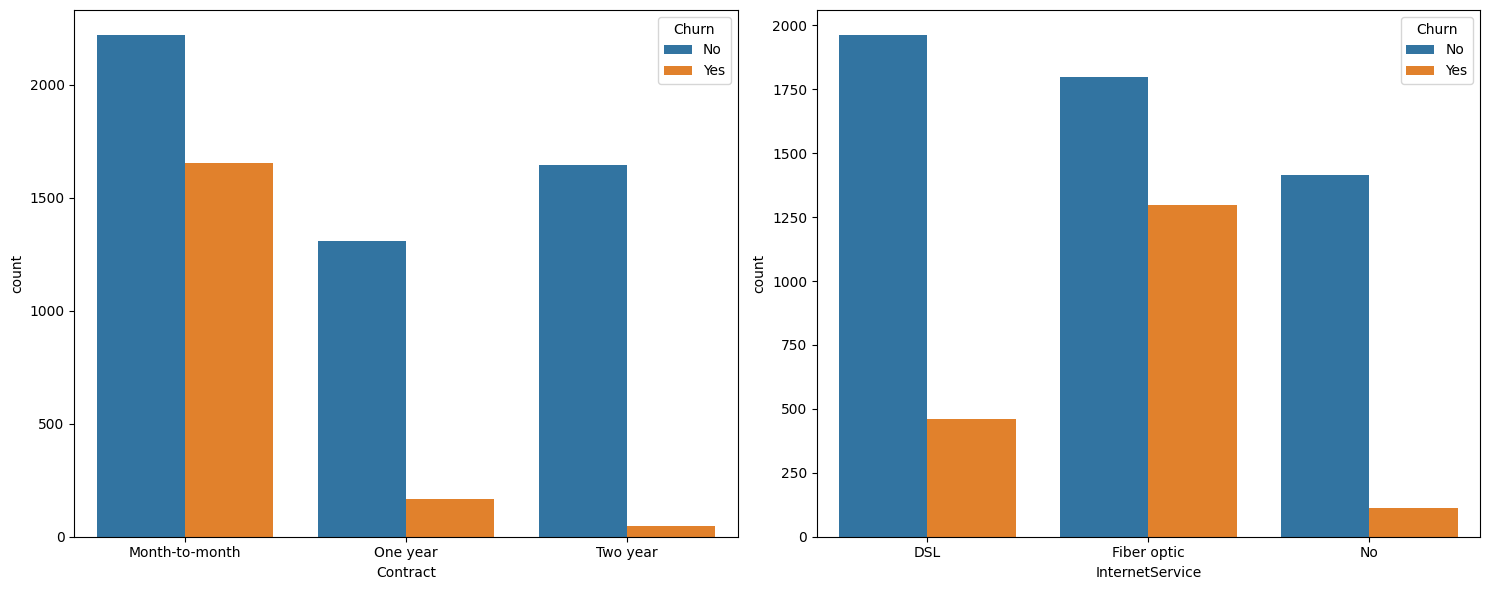

In [45]:
# Análisis de contratos y servicios
fig, ax = plt.subplots(1, 2, figsize=(15,6)) # Crear una figura con 2 subgráficas en una fila
sns.countplot(x='Contract', hue='Churn', data=data, ax=ax[0]) # Crear un gráfico de barras para 'Contract' vs 'Churn'
sns.countplot(x='InternetService', hue='Churn', data=data, ax=ax[1]) # Crear un gráfico de barras para 'InternetService' vs 'Churn'
plt.tight_layout()
plt.show()

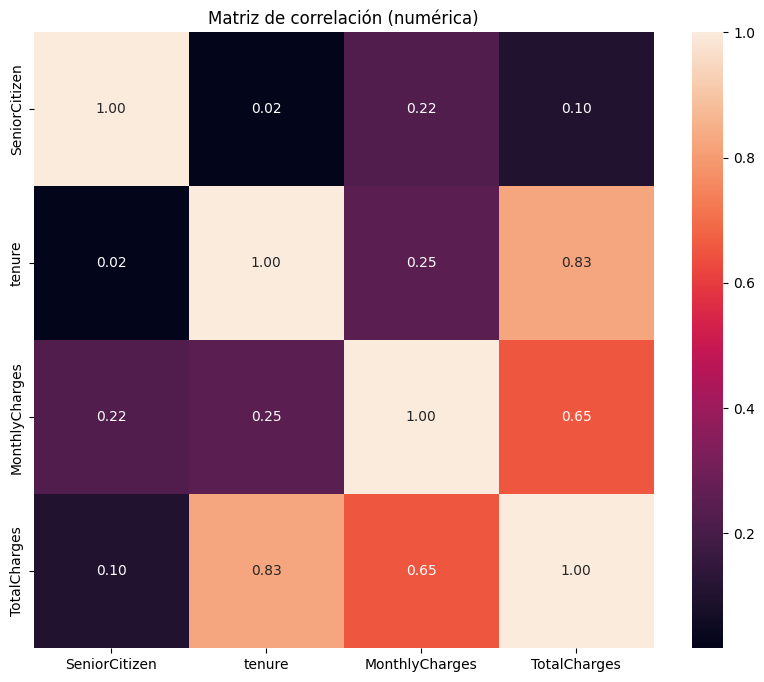

In [46]:
plt.figure(figsize=(10,8))
sns.heatmap(data.select_dtypes('number').corr(), annot=True, fmt=".2f")
plt.title("Matriz de correlación (numérica)")
plt.show()


# Preprocesamiento

In [47]:
# Eliminar clienteID
data = data.drop('customerID', axis=1) 

In [48]:
# Corregir TotalCharges
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce') # Reconvertir 'TotalCharges' a numérico, reemplazando errores con NaN# Corregir TotalCharges


In [49]:
# Convertir Churn a binario
data['Churn'] = data['Churn'].map({'No':0, 'Yes':1}) # Convertir la columna 'Churn' a valores binarios (0 y 1)

In [50]:
# Identificar columnas por tipo
categorical_cols = data.select_dtypes(include=['object']).columns.tolist() # Seleccionar columnas categóricas
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges'] # Definir columnas numéricas

In [51]:
# Tratamiento de valores faltantes
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median()) # Rellenar valores faltantes numéricos con la mediana

In [52]:
# Crear antigüedad en años
data['tenure_years'] = data['tenure'] / 12 # Calcular la antigüedad en años dividiendo 'tenure' por 12

In [53]:
# División estratificada de datos
X = data.drop('Churn', axis=1) # Eliminar la columna 'Churn' para crear el conjunto de características
y = data['Churn'] # Seleccionar la columna 'Churn' como variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True) # Dividir los datos en conjuntos de entrenamiento y prueba, asegurando que la proporción de clases se mantenga

# Pipeline de Transformación

In [54]:
# Transformadores para columnas numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]) # Transformador para columnas numéricas que imputa valores faltantes con la mediana y escala los datos

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),# Transformador para columnas categóricas que imputa valores faltantes con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))# Transformador para columnas categóricas que imputa valores faltantes con el valor más frecuente y aplica codificación one-hot
]) # Transformador para columnas categóricas que imputa valores faltantes con el valor más frecuente y aplica codificación one-hot

# Combinar transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols), # Combinar los transformadores numéricos
        ('cat', categorical_transformer, categorical_cols)  # Combinar los transformadores categóricos
]) # Combinar los transformadores en un preprocesador que aplica cada uno a las columnas correspondientes

# Modelado con Validación Cruzada

In [55]:
# Definir modelos con hiperparámetros iniciales
models = {
"Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), # Modelo de regresión logística con ponderación de clases balanceada y un máximo de 1000 iteraciones
"Decision Tree": DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42),  # Modelo de árbol de decisión con profundidad máxima de 5 y ponderación de clases balanceada
"Random Forest": RandomForestClassifier(class_weight='balanced_subsample', n_estimators=100, random_state=42) # Modelo de bosque aleatorio con ponderación de clases balanceada por submuestra y 100 árboles    
} 

In [56]:
# Entrenar y evaluar con validación cruzada estratificada
results = {} # Diccionario para almacenar los resultados de cada modelo
for name, model in models.items():
    # Crear pipeline completo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor), # Aplicar el preprocesador a las características
        ('classifier', model)   # Aplicar el modelo de clasificación al preprocesador
    ]) # Crear un pipeline que primero aplica el preprocesador y luego el clasificador
    
    # Validación cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)# Crear un objeto de validación cruzada estratificada con 5 pliegues, barajando los datos y fijando una semilla aleatoria para reproducibilidad
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro') # Realizar validación cruzada estratificada con 5 pliegues y calcular la puntuación F1 macro
    
    # Entrenar modelo final
    pipeline.fit(X_train, y_train) # Ajustar el pipeline al conjunto de entrenamiento
    
    # Predecir en test
    y_pred = pipeline.predict(X_test) # Predecir las etiquetas del conjunto de prueba
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [0]*len(y_test) # Predecir las probabilidades de la clase positiva en el conjunto de prueba, o asignar 0 si el modelo no tiene el método predict_proba
    
    # Calcular métricas
    results[name] = {
        'model': pipeline, # Guardar el pipeline del modelo
        'cv_mean_f1': np.mean(cv_scores),   # Calcular la media de las puntuaciones F1 de la validación cruzada
        'test_accuracy': accuracy_score(y_test, y_pred),    # Calcular la precisión del modelo en el conjunto de prueba
        'test_precision': precision_score(y_test, y_pred),  # Calcular la precisión del modelo en el conjunto de prueba
        'test_recall': recall_score(y_test, y_pred),    # Calcular el recall del modelo en el conjunto de prueba
        'test_f1': f1_score(y_test, y_pred),    # Calcular la puntuación F1 del modelo en el conjunto de prueba
        'test_roc_auc': roc_auc_score(y_test, y_proba) if len(np.unique(y_proba)) > 1 else 0.5  # Calcular el área bajo la curva ROC del modelo en el conjunto de prueba, o asignar 0.5 si no hay variación en las probabilidades
    }
    
    print(f"\n{name} - F1 CV: {results[name]['cv_mean_f1']:.4f} | F1 Test: {results[name]['test_f1']:.4f}")# Mostrar las puntuaciones F1 de la validación cruzada y del conjunto de prueba para cada modelo


Logistic Regression - F1 CV: 0.7201 | F1 Test: 0.6083

Decision Tree - F1 CV: 0.7106 | F1 Test: 0.6206

Random Forest - F1 CV: 0.6958 | F1 Test: 0.5145


# Evaluación y Análisis

In [57]:
# Crear dataframe comparativo
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()  # Convertir el diccionario de resultados en un DataFrame, usando los nombres de los modelos como índice
results_df = results_df.rename(columns={'index': 'Model'})  # Renombrar la columna del índice a 'Model'
print(results_df[['Model', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']]) # Mostrar las métricas de rendimiento de cada modelo en el conjunto de prueba

                 Model  test_accuracy  test_precision  test_recall   test_f1  \
0  Logistic Regression       0.733144        0.498294     0.780749  0.608333   
1        Decision Tree       0.754436        0.526022     0.756684  0.620614   
2        Random Forest       0.773598        0.597173     0.451872  0.514460   

   test_roc_auc  
0      0.840401  
1      0.831799  
2      0.816336  


In [58]:
# Matriz de confusión para el mejor modelo
best_model_name = results_df.loc[results_df['test_f1'].idxmax(), 'Model'] # Obtener el nombre del modelo con la mejor puntuación F1 en el conjunto de prueba
best_model = results[best_model_name]['model']  # Obtener el pipeline del mejor modelo

print(f"\nMejor modelo: {best_model_name}") #   Mostrar el nombre del mejor modelo
print(classification_report(y_test, best_model.predict(X_test))) # Mostrar el informe de clasificación del mejor modelo, que incluye precisión, recall y F1-score para cada clase


Mejor modelo: Decision Tree
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.76      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.77      1409



# Interpretación de Modelos

In [60]:
# Para Regresión Logística: coeficientes
if "Logistic Regression" in results:
    lr_model = results["Logistic Regression"]['model']  # Obtener el pipeline del modelo de regresión logística
    # Obtener nombres de características después del one-hot encoding
    ohe = lr_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']# Obtener el transformador OneHotEncoder del preprocesador
    cat_features = ohe.get_feature_names_out(categorical_cols)# Obtener los nombres de las características categóricas después del one-hot encoding
    all_features = numeric_cols + list(cat_features)# Combinar las características numéricas y categóricas para obtener todas las características del modelo
    
    # Obtener coeficientes
    coefficients = lr_model.named_steps['classifier'].coef_[0]# Obtener los coeficientes del modelo de regresión logística, que son los pesos asignados a cada característica
    feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': coefficients})# Crear un DataFrame con las características y sus importancias (coeficientes)
    feature_importance = feature_importance.sort_values('Importance', key=abs, ascending=False).head(10)# Seleccionar las 10 características más importantes según el valor absoluto de los coeficientes y ordenarlas de mayor a menor importancia
    
    print("\nTop 10 variables más importantes (Regresión Logística):")
    print(feature_importance)



Top 10 variables más importantes (Regresión Logística):
                                 Feature  Importance
0                                 tenure   -1.140390
37                     Contract_Two year   -0.786209
15           InternetService_Fiber optic    0.710123
1                         MonthlyCharges   -0.670039
35               Contract_Month-to-month    0.669807
14                   InternetService_DSL   -0.625980
2                           TotalCharges    0.481538
24  DeviceProtection_No internet service   -0.275962
16                    InternetService_No   -0.275962
18    OnlineSecurity_No internet service   -0.275962


In [61]:
# Para Random Forest: importancia de características
if "Random Forest" in results: # Verificar si el modelo de Random Forest está en los resultados
    rf_model = results["Random Forest"]['model']    # Obtener el pipeline del modelo de Random Forest
    importances = rf_model.named_steps['classifier'].feature_importances_   # Obtener las importancias de las características del modelo de Random Forest, que indican la relevancia de cada característica para la predicción
    feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': importances}) # Crear un DataFrame con las características y sus importancias
    feature_importance = feature_importance.sort_values('Importance', ascending=False).head(10) # Seleccionar las 10 características más importantes y ordenarlas de mayor a menor importancia
    
    print("\nTop 10 variables más importantes (Random Forest):")
    print(feature_importance)


Top 10 variables más importantes (Random Forest):
                           Feature  Importance
2                     TotalCharges    0.146905
0                           tenure    0.133368
1                   MonthlyCharges    0.131205
35         Contract_Month-to-month    0.069408
26                  TechSupport_No    0.038995
37               Contract_Two year    0.036208
17               OnlineSecurity_No    0.030506
42  PaymentMethod_Electronic check    0.025109
15     InternetService_Fiber optic    0.022897
3                    gender_Female    0.016880


In [62]:
# Definición de modelos
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),# Modelo de regresión logística con ponderación de clases balanceada y un máximo de 1000 iteraciones
    'Decision Tree':      DecisionTreeClassifier(class_weight='balanced', random_state=42),# Modelo de árbol de decisión con ponderación de clases balanceada
    'Random Forest':      RandomForestClassifier(class_weight='balanced_subsample', random_state=42) # Modelo de bosque aleatorio con ponderación de clases balanceada por submuestra
}

# Espacios de búsqueda sin usar “…” Unicode
param_distributions = {
    'Logistic Regression': {
        'classifier__C':        stats.loguniform(1e-3, 1e3),# Distribución logarítmica uniforme para el parámetro de regularización C
        'classifier__solver':   ['lbfgs', 'saga'],  #  Solvers para la regresión logística
        'classifier__penalty':  ['l2']  # Penalización L2 para la regresión logística
    },
    'Decision Tree': {
        'classifier__max_depth':        stats.randint(3, 15), # Profundidad máxima del árbol de decisión
        'classifier__min_samples_leaf': stats.randint(1, 10),   # Mínimo de muestras por hoja
        'classifier__criterion':        ['gini', 'entropy'] # Criterios de división para el árbol de decisión
    },
    'Random Forest': {
        'classifier__n_estimators': stats.randint(50, 300), # Número de árboles en el bosque aleatorio
        'classifier__max_depth':    stats.randint(5, 20), # Profundidad máxima de los árboles
        'classifier__max_features': ['sqrt', 'log2', None], # Número de características a considerar al buscar la mejor división
        'classifier__criterion':    ['gini', 'entropy'] # Criterios de división para el bosque aleatorio
    }
}
# Crear un diccionario con los espacios de búsqueda de hiperparámetros para cada modelo, utilizando distribuciones adecuadas para cada parámetro
search_results = {} 
for name, model in models.items():  # Iterar sobre los modelos definidos
    pipeline = Pipeline([   # Crear un pipeline que combine el preprocesador y el modelo
        ('preprocessor', preprocessor), # Aplicar el preprocesador a las características
        ('classifier',    model) # Aplicar el modelo de clasificación al preprocesador
    ])

    rs = RandomizedSearchCV( # Crear un objeto RandomizedSearchCV para la búsqueda aleatoria de hiperparámetros
        estimator=pipeline, # Usar el pipeline como estimador
        param_distributions=param_distributions[name],  # Usar el espacio de búsqueda específico para cada modelo
        n_iter=30,  # Número de iteraciones de búsqueda aleatoria
        scoring='f1_macro',     # Usar la puntuación F1 macro como métrica de evaluación
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # Validación cruzada estratificada con 5 pliegues
        random_state=42, # Fijar una semilla aleatoria para reproducibilidad
        n_jobs=-1, # Usar todos los núcleos disponibles para la búsqueda
        verbose=1 # Mostrar información detallada durante la búsqueda
    )
    rs.fit(X_train, y_train)    # Ajustar el RandomizedSearchCV al conjunto de entrenamiento
    search_results[name] = rs # Guardar los resultados de la búsqueda para cada modelo

    print(f"{name} → Mejor F1 CV: {rs.best_score_:.4f}")  # Mostrar la mejor puntuación F1 de la validación cruzada para el modelo actual
    print("Parámetros óptimos:")
    for p, v in rs.best_params_.items(): # Mostrar los parámetros óptimos encontrados por la búsqueda aleatoria
        print(f"  • {p}: {v}") # Imprimir cada parámetro óptimo con su valor correspondiente
# Evaluación final de los mejores modelos


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Logistic Regression → Mejor F1 CV: 0.7213
Parámetros óptimos:
  • classifier__C: 0.10051981180656774
  • classifier__penalty: l2
  • classifier__solver: saga
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Decision Tree → Mejor F1 CV: 0.7145
Parámetros óptimos:
  • classifier__criterion: entropy
  • classifier__max_depth: 3
  • classifier__min_samples_leaf: 4
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Random Forest → Mejor F1 CV: 0.7393
Parámetros óptimos:
  • classifier__criterion: entropy
  • classifier__max_depth: 11
  • classifier__max_features: sqrt
  • classifier__n_estimators: 239


Mejor modelo: Random Forest

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.87      0.80      0.84      1035
           1       0.55      0.68      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.78      1409



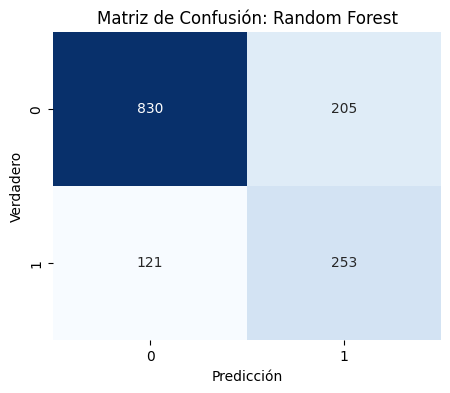

In [63]:


# 1. Seleccionar el mejor pipeline tras RandomizedSearchCV
best_name     = max(search_results, key=lambda n: search_results[n].best_score_) #  Obtener el nombre del modelo con la mejor puntuación F1 de la validación cruzada
best_pipeline = search_results[best_name].best_estimator_ # Obtener el pipeline del mejor modelo encontrado por la búsqueda aleatoria
print(f"Mejor modelo: {best_name}\n") # Mostrar el nombre del mejor modelo encontrado por la búsqueda aleatoria

# 2. Re-entrenar en todo el train set (ya lo hizo RS; opcional refit=True)
# best_pipeline.fit(X_train, y_train)

# 3. Predecir labels y probabilidades
y_pred  = best_pipeline.predict(X_test) # Predecir las etiquetas del conjunto de prueba usando el mejor pipeline
y_proba = best_pipeline.predict_proba(X_test)[:,1] #    Predecir las probabilidades de la clase positiva en el conjunto de prueba usando el mejor pipeline

# 4. Informe de clasificación

print("=== Classification Report ===")
print(classification_report(y_test, y_pred)) # Mostrar el informe de clasificación que incluye precisión, recall y F1-score para cada clase


# 5. Matriz de confusión anotada
cm = confusion_matrix(y_test, y_pred)   # Calcular la matriz de confusión entre las etiquetas verdaderas y las predicciones del modelo
plt.figure(figsize=(5,4))   #
sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title(f"Matriz de Confusión: {best_name}") # Mostrar el título de la matriz de confusión con el nombre del mejor modelo
plt.show()





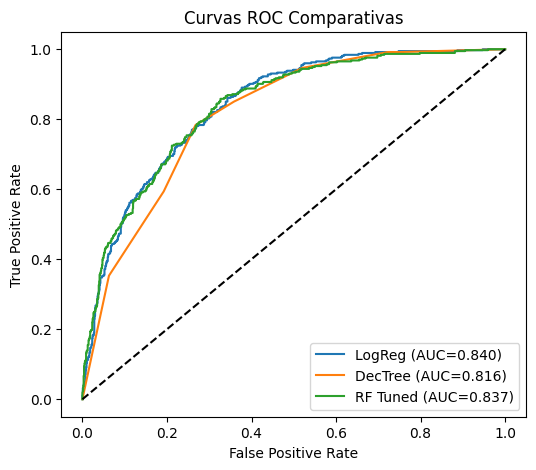

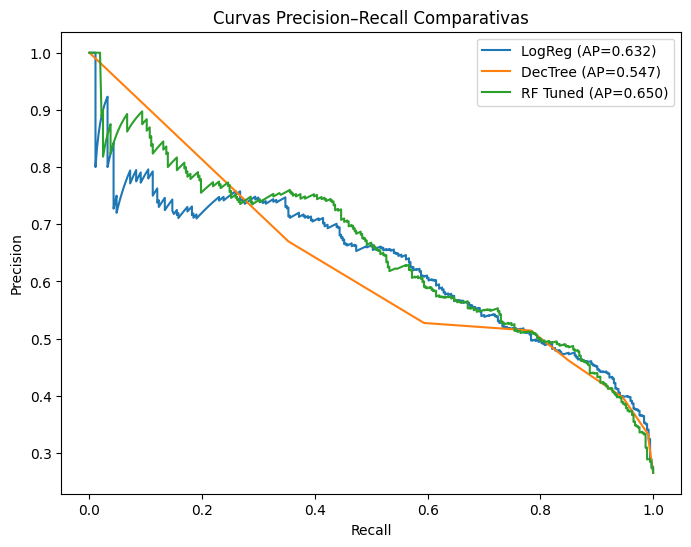

In [64]:
# 1. Seleccionar los mejores pipelines tras RandomizedSearchCV
lr_pipeline      = search_results["Logistic Regression"].best_estimator_ # Obtener el mejor pipeline de regresión logística
dt_pipeline      = search_results["Decision Tree"].best_estimator_ # Obtener el mejor pipeline de árbol de decisión
rf_tuned_pipeline = search_results["Random Forest"].best_estimator_ # Obtener el mejor pipeline de bosque aleatorio

# 2. Curvas ROC comparativas
plt.figure(figsize=(6,5))
for name, pipe in [ #   Iterar sobre los pipelines de los modelos seleccionados
    ("LogReg", lr_pipeline),    # Asignar nombre y pipeline de regresión logística
    ("DecTree", dt_pipeline),   # Asignar nombre y pipeline de árbol de decisión
    ("RF Tuned", rf_tuned_pipeline) # Asignar nombre y pipeline de bosque aleatorio afinado
]:
    y_prob = pipe.predict_proba(X_test)[:,1] # Predecir las probabilidades de la clase positiva en el conjunto de prueba usando el pipeline actual
    fpr, tpr, _ = roc_curve(y_test, y_prob) # Calcular la curva ROC para el modelo actual
    auc = roc_auc_score(y_test, y_prob)     # Calcular el área bajo la curva ROC para el modelo actual
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})") # Dibujar la curva ROC en el gráfico, etiquetando con el nombre del modelo y el AUC correspondiente
plt.plot([0,1],[0,1],'k--') # Dibujar una línea diagonal de referencia (AUC = 0.5)
plt.xlabel("False Positive Rate")   # Etiquetar el eje X como "Tasa de Falsos Positivos"
plt.ylabel("True Positive Rate")    # Etiquetar el eje Y como "Tasa de Verdaderos Positivos"
plt.title("Curvas ROC Comparativas") 
plt.legend() 
plt.show()

# 3. Curvas Precision–Recall comparativas
plt.figure(figsize=(8,6))
for name, pipe in [ # Iterar sobre los pipelines de los modelos seleccionados
    ("LogReg", lr_pipeline), # Asignar nombre y pipeline de regresión logística
    ("DecTree", dt_pipeline),  # Asignar nombre y pipeline de árbol de decisión
    ("RF Tuned", rf_tuned_pipeline) # Asignar nombre y pipeline de bosque aleatorio afinado
]:
    y_prob = pipe.predict_proba(X_test)[:,1] # Predecir las probabilidades de la clase positiva en el conjunto de prueba usando el pipeline actual
    precision, recall, _ = precision_recall_curve(y_test, y_prob) # Calcular la curva de precisión-recall usando las probabilidades predichas
    ap = average_precision_score(y_test, y_prob) # Calcular la puntuación de precisión promedio (AP) usando las probabilidades predichas
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})") # Dibujar la curva de precisión-recall en el gráfico, etiquetando con el nombre del modelo y la puntuación de precisión promedio correspondiente
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision–Recall Comparativas")
plt.legend()
plt.show()
